# Desafio Semana 8 : Enem 2


**Descubra as melhores notas de matemática do ENEM 2016** <br>
Você deverá criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016.
<br>
Para isso, usará Python, Pandas, Sklearn e Regression.<br>
<br>
**Detalhes**
<br>
O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o Dicionário dos Microdados do Enem 2016.<br>
<br>
No arquivo test.csv crie um modelo para prever nota da prova de matemática (coluna NU_NOTA_MT) de quem participou do ENEM 2016.<br>
<br>
Salve sua resposta em um arquivo chamado answer.csv com duas colunas: NU_INSCRICAO e NU_NOTA_MT.<br>


**Variável Alvo:** NU_NOTA_MT

In [2]:
# Importação das bibliotecas:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#biblioteca de pré-processamento
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#biblioteca de featuring engineering
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


#biblioteca de métricas
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

##**Análise Exploratória**

In [4]:
# Importando arquivos de dados:
df_test = pd.read_csv('/content/drive/My Drive/enem-2/test.csv')
df_train = pd.read_csv('/content/drive/My Drive/enem-2/train.csv')

In [5]:
# Realizando cópia dos df
df_test_orig = df_test.copy()
df_train_orig = df_train.copy()

In [6]:
# Verificando o tamanho dos datasets:
df_train.shape, df_test.shape

((13730, 167), (4576, 47))

Observa-se diferença no número de colunas entre os dados de treino e teste. 

In [7]:
# Verificar se os dados de teste estão inclusos no dataset de treino
print(set(df_test.columns).issubset(set(df_train.columns)))

True


In [8]:
# Transformando coluna NU_INSCRIÇÃO em index
df_train = df_train.set_index('NU_INSCRICAO')
df_test = df_test.set_index('NU_INSCRICAO')

In [9]:
# Selecionando as colunas presentes no df_treino + variável alvo
col_commom = list(df_test.columns)
col_commom.append('NU_NOTA_MT')
#col_commom

In [10]:
# Aplicando a seleção das colunas no df de treino
df_train = df_train[col_commom]

In [11]:
# Verificando as colunas no dataset de treino
df_train.columns

Index(['CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC',
       'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA',
       'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO',
       'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'CO_PROVA_CN',
       'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026',
       'Q027', 'Q047', 'NU_NOTA_MT'],
      dtype='object')

De acordo com o dicionário de dados e colunas acima, observam-se que existem variáveis que representam códigos que não apresentam nenhuma relevância ao modelo. Portanto, serão removidas dos datasets.

In [12]:
# Remoção de colunas não relevantes 1 - Códigos de Prova
codigos = ['CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT']
df_train = df_train.drop(codigos, axis=1)
df_test = df_test.drop(codigos, axis=1)

In [13]:
# Creating DataFrame for Data Manipulation - Train Data
print('Creating DataFrame for Data Manipulation - TRAIN DATA')
aux = pd.DataFrame({'column': df_train.columns,
                    'dtype': df_train.dtypes,
                    'missing': df_train.isna().sum(),
                    'size': df_train.shape[0],
                    'unique': df_train.nunique(),
                    'missing_perc': ((df_train.isna().sum() / df_train.shape[0]) * 100).round(2)},
                    )
aux.sort_values('missing_perc', ascending=False)

Creating DataFrame for Data Manipulation - TRAIN DATA


,column,dtype,missing,size,unique,missing_perc
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,9448,13730,4,68.81
TP_ENSINO,TP_ENSINO,float64,9448,13730,3,68.81
Q027,Q027,object,7373,13730,13,53.70
NU_NOTA_REDACAO,NU_NOTA_REDACAO,float64,3597,13730,53,26.20
NU_NOTA_LC,NU_NOTA_LC,float64,3597,13730,2774,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,3597,13730,9,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,3597,13730,15,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,3597,13730,13,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,3597,13730,12,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,3597,13730,14,26.20


In [14]:
# Creating DataFrame for Data Manipulation - TEST DATA
print('Creating DataFrame for Data Manipulation - Test Data')
aux = pd.DataFrame({'column': df_test.columns,
                    'dtype': df_test.dtypes,
                    'missing': df_test.isna().sum(),
                    'size': df_test.shape[0],
                    'unique': df_test.nunique(),
                    'missing_perc': ((df_test.isna().sum() / df_test.shape[0]) * 100).round(2)},
                    )
aux.sort_values('missing_perc', ascending=False)


Creating DataFrame for Data Manipulation - Test Data


,column,dtype,missing,size,unique,missing_perc
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,3096,4576,4,67.66
TP_ENSINO,TP_ENSINO,float64,3096,4576,3,67.66
Q027,Q027,object,2488,4576,13,54.37
NU_NOTA_COMP5,NU_NOTA_COMP5,float64,1199,4576,11,26.20
NU_NOTA_LC,NU_NOTA_LC,float64,1199,4576,1839,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,1199,4576,9,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,1199,4576,10,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,1199,4576,10,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,1199,4576,11,26.20
NU_NOTA_REDACAO,NU_NOTA_REDACAO,float64,1199,4576,44,26.20


As features IN_CEGUEIRA, IN_DISLEXIA, IN_DISCALCULIA apresentam apenas 1 valor único no dataset de teste, portanto não tem variância e não são relevantes para o modelo. Serão removidas no df_treino e df_test.

In [15]:
# Remoção de colunas não relevantes 2 - Colunas com um único valor (sem variância)
feat_unique = ['IN_CEGUEIRA', 'IN_DISLEXIA', 'IN_DISCALCULIA']
df_train = df_train.drop(feat_unique, axis=1)
df_test = df_test.drop(feat_unique, axis=1)

## **Exploração dos dados**

In [16]:
# Verificando todas as correlações com a variável alvo:
cor = pd.DataFrame(df_train.corr().NU_NOTA_MT)
cor['missing_perc'] = ((df_train.isna().sum() / df_train.shape[0]) * 100).round(2)
cor.sort_values('NU_NOTA_MT', ascending=False)

,NU_NOTA_MT,missing_perc
NU_NOTA_MT,1.00,26.20
NU_NOTA_CN,0.58,24.68
NU_NOTA_CH,0.53,24.68
NU_NOTA_LC,0.49,26.20
NU_NOTA_REDACAO,0.38,26.20
TP_DEPENDENCIA_ADM_ESC,0.37,68.81
NU_NOTA_COMP3,0.35,26.20
NU_NOTA_COMP5,0.34,26.20
NU_NOTA_COMP4,0.34,26.20
NU_NOTA_COMP2,0.34,26.20


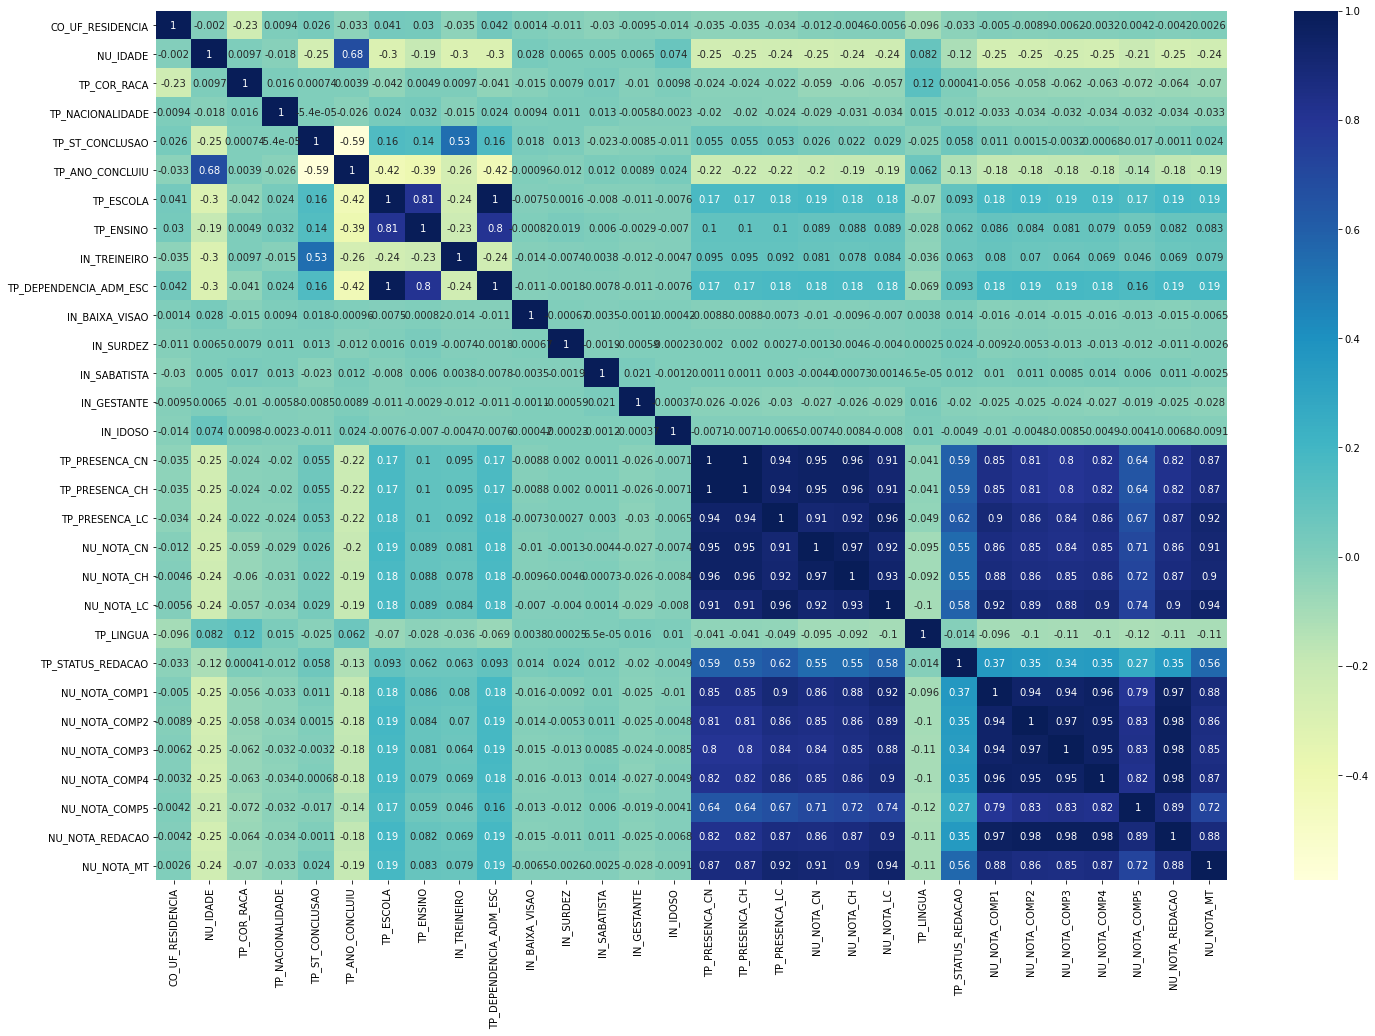

In [83]:
# Plotando as correlações em um heatmap
corr = df_train.corr()
ax = plt.subplots(figsize=(24, 16))
sns.heatmap(corr,  annot=True, cmap="YlGnBu")

A feature TP_PRESENCA_LC apresentou NaN na correlação com a variável alvo. Segundo o dicionário de dados, essa feature representa a presença do aluno na prova de Linguagens e Códigos (LC). Além disso, outra informação relevante é de que a prova de LC é realizada no mesmo dia da prova de Matemática e Tecnologia (MT), portanto, podemos inferir que a ausência na prova de LC é igual a ausência na prova de MT.

In [17]:
df_train['TP_PRESENCA_LC'].value_counts()

1    10133
0     3592
2        5
Name: TP_PRESENCA_LC, dtype: int64

In [18]:
df_test['TP_PRESENCA_LC'].value_counts()

1    3377
0    1195
2       4
Name: TP_PRESENCA_LC, dtype: int64

Observa-se que nos dados de teste 1195 candidatos não compareceram a prova de LC e, por consequencia, não terão nota na prova de MT. O que pode ser uma grande fonte de ruído. 

### Exploração dos dados de treino

In [19]:
# Separando as colunas categóricsa (não-numéricas)
df_train_cat = df_train.select_dtypes(exclude='number')
df_test_cat = df_test.select_dtypes(exclude='number')
# Creating DataFrame for Data Manipulation
print('Creating DataFrame for Data Manipulation - Treino Categóricas')
aux = pd.DataFrame({'column': df_train_cat.columns,
                    'dtype': df_train_cat.dtypes,
                    'missing': df_train_cat.isna().sum(),
                    'size': df_train_cat.shape[0],
                    'unique': df_train_cat.nunique(),
                    'missing_perc': ((df_train_cat.isna().sum() / df_train_cat.shape[0]) * 100).round(2)
                   })
aux.sort_values('missing_perc', ascending=False)

Creating DataFrame for Data Manipulation - Treino Categóricas


,column,dtype,missing,size,unique,missing_perc
Q027,Q027,object,7373,13730,13,53.70
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.00
TP_SEXO,TP_SEXO,object,0,13730,2,0.00
Q001,Q001,object,0,13730,8,0.00
Q002,Q002,object,0,13730,8,0.00
Q006,Q006,object,0,13730,17,0.00
Q024,Q024,object,0,13730,5,0.00
Q025,Q025,object,0,13730,2,0.00
Q026,Q026,object,0,13730,3,0.00
Q047,Q047,object,0,13730,5,0.00


In [20]:
# Separando as colunas numéricas
df_train_num = df_train.select_dtypes(include='number')
df_test_num = df_test.select_dtypes(include='number')
# Creating DataFrame for Data Manipulation
print('Creating DataFrame for Data Manipulation - Treino Numéricas')
aux = pd.DataFrame({'column': df_train_num.columns,
                    'dtype': df_train_num.dtypes,
                    'missing': df_train_num.isna().sum(),
                    'size': df_train_num.shape[0],
                    'unique': df_train_num.nunique(),
                    'missing_perc': ((df_train_num.isna().sum() / df_train_num.shape[0]) * 100).round(2)
                    })
aux.sort_values('missing_perc', ascending=False)

Creating DataFrame for Data Manipulation - Treino Numéricas


,column,dtype,missing,size,unique,missing_perc
TP_ENSINO,TP_ENSINO,float64,9448,13730,3,68.81
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,9448,13730,4,68.81
NU_NOTA_MT,NU_NOTA_MT,float64,3597,13730,3406,26.20
NU_NOTA_REDACAO,NU_NOTA_REDACAO,float64,3597,13730,53,26.20
NU_NOTA_COMP5,NU_NOTA_COMP5,float64,3597,13730,14,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,3597,13730,14,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,3597,13730,12,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,3597,13730,13,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,3597,13730,15,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,3597,13730,9,26.20


Histograma dataset de treino


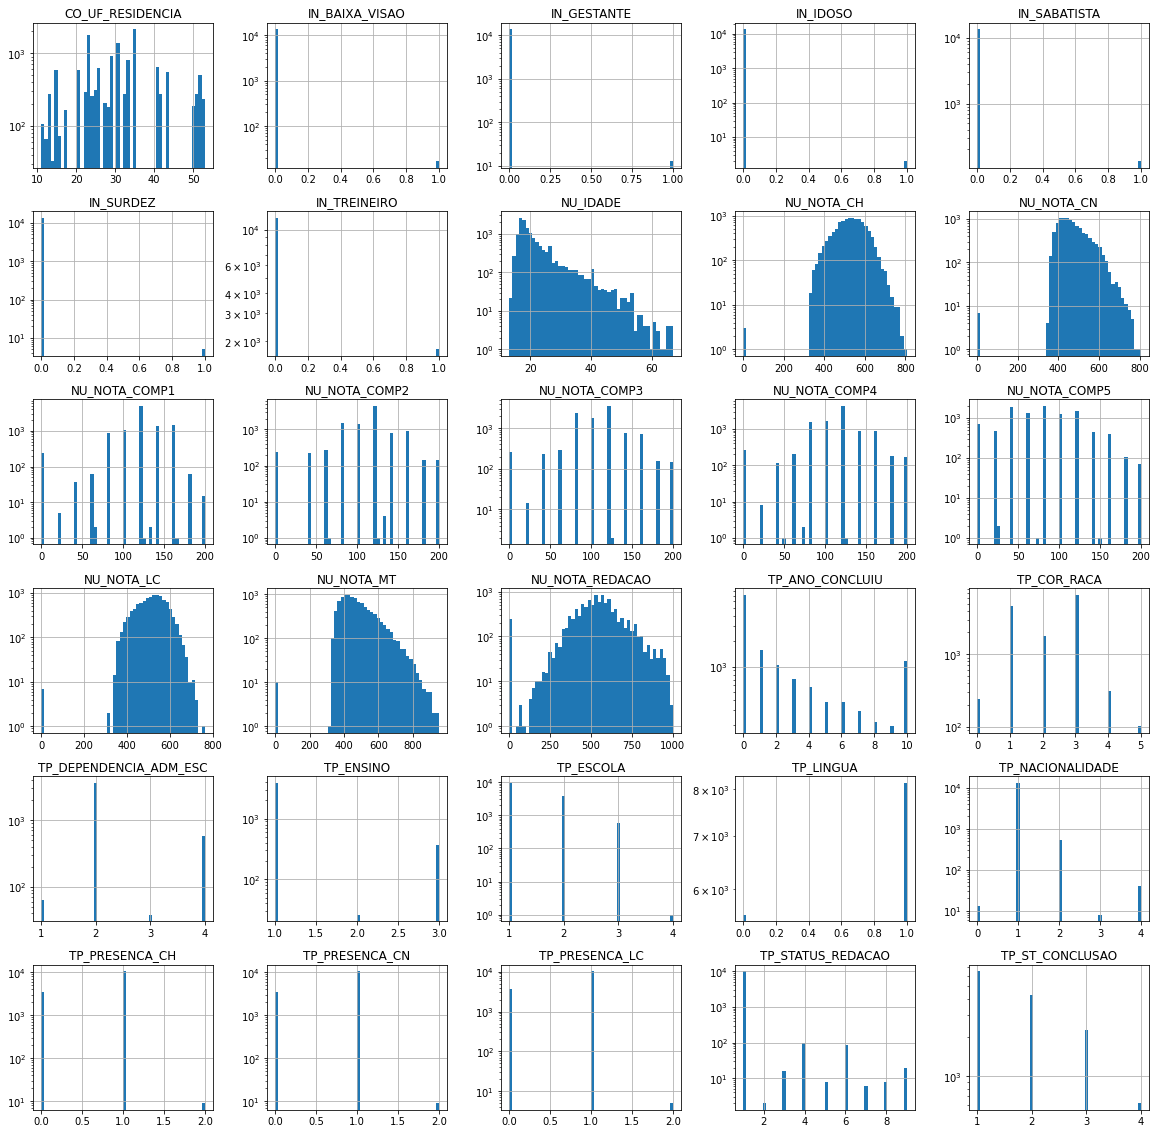

In [21]:
# Explorando a distribuição das variáveis numéricas
df_train_num.hist(bins=50,log=True, figsize=(20, 20))
print('Histograma dataset de treino')
plt.show()

## Estratégia 1 para substituir os nulos: completar com zeros

### Dados de treinamento

In [22]:
# Criando uma lista de colunas categóricas e numericas
list_cat = list(df_train_cat.columns)
list_num = list(df_train_num.columns)
# Completando dados faltantes com zero (0)
df_train[list_cat] = df_train[list_cat].fillna('0')
df_train[list_num] = df_train[list_num].fillna(0)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13730 entries, ed50e8aaa58e7a806c337585efee9ca41f1eb1ad to 0af8939c470a600b30bdaa80375ee0db848b0e35
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CO_UF_RESIDENCIA        13730 non-null  int64  
 1   SG_UF_RESIDENCIA        13730 non-null  object 
 2   NU_IDADE                13730 non-null  int64  
 3   TP_SEXO                 13730 non-null  object 
 4   TP_COR_RACA             13730 non-null  int64  
 5   TP_NACIONALIDADE        13730 non-null  int64  
 6   TP_ST_CONCLUSAO         13730 non-null  int64  
 7   TP_ANO_CONCLUIU         13730 non-null  int64  
 8   TP_ESCOLA               13730 non-null  int64  
 9   TP_ENSINO               13730 non-null  float64
 10  IN_TREINEIRO            13730 non-null  int64  
 11  TP_DEPENDENCIA_ADM_ESC  13730 non-null  float64
 12  IN_BAIXA_VISAO          13730 non-null  int64  
 13  IN_SURDEZ             

### Dados de Teste
Aplicando as mesmas transformações no dataset de treino

In [23]:
# Criando uma lista de colunas categóricas e numericas
list_cat1 = list(df_test_cat.columns)
list_num1 = list(df_test_num.columns)
# Completando dados faltantes com zero (0)
df_test[list_cat1] = df_test[list_cat1].fillna('0')
df_test[list_num1] = df_test[list_num1].fillna(0)

df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4576 entries, 73ff9fcc02f0a99919906c942c2e1a1042cdcf98 to adf0d15b54317b6564ef56dad2b775bbb0ef50cc
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CO_UF_RESIDENCIA        4576 non-null   int64  
 1   SG_UF_RESIDENCIA        4576 non-null   object 
 2   NU_IDADE                4576 non-null   int64  
 3   TP_SEXO                 4576 non-null   object 
 4   TP_COR_RACA             4576 non-null   int64  
 5   TP_NACIONALIDADE        4576 non-null   int64  
 6   TP_ST_CONCLUSAO         4576 non-null   int64  
 7   TP_ANO_CONCLUIU         4576 non-null   int64  
 8   TP_ESCOLA               4576 non-null   int64  
 9   TP_ENSINO               4576 non-null   float64
 10  IN_TREINEIRO            4576 non-null   int64  
 11  TP_DEPENDENCIA_ADM_ESC  4576 non-null   float64
 12  IN_BAIXA_VISAO          4576 non-null   int64  
 13  IN_SURDEZ              

## Criando variáveis para treinar o modelo

In [24]:
# Criando variáveis explicativas (X) e dependente (Y).
X = df_train.drop('NU_NOTA_MT', axis=1)
y = df_train['NU_NOTA_MT']

### **Pré-processamento dos dados**

### Dados de Treino

In [25]:
X.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,0.00,0,0.00,0,0,0,0,0,1,1,1,436.30,495.40,581.20,1,1.00,120.00,120.00,120.00,80.00,80.00,520.00,D,D,C,A,A,C,H,A
2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,1.00,0,2.00,0,0,0,0,0,1,1,1,474.50,544.10,599.00,1,1.00,140.00,120.00,120.00,120.00,80.00,580.00,A,A,B,A,A,A,0,A
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,0.00,0,0.00,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,D,D,C,A,A,A,0,A
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,0.00,0,0.00,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,H,E,E,C,B,C,F,D
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,0.00,0,0.00,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,E,D,C,A,A,B,F,A


In [26]:
# Selecionando os pré-processadores
encoder = OneHotEncoder(sparse=False)
scaler = StandardScaler()

In [27]:
# Aplicando o pré-processamento
for coluna in X.columns[1:]:
  try:
    X[coluna] = encoder.fit_transform(X[[coluna]])
    X[coluna] = scaler.fit_transform(X[[coluna]])
  except:
    print(f'Não foi possível realizar a operação para a coluna {coluna}')

In [28]:
X.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,-0.07,-0.01,-1.27,-0.13,-0.03,1.05,-1.05,0.67,0.67,0.39,0.67,0.04,0.02,0.10,0.03,0.01,-0.57,-0.57,-0.60,-0.57,-0.57,-0.60,-0.83,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.27,-0.22,-0.19,1.12,1.15,-1.05,-1.08,0.41
2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,-0.07,-0.01,0.79,-0.13,-0.03,-0.95,0.95,-1.49,-1.49,0.39,-1.49,0.04,0.02,0.10,0.03,0.01,-0.57,-0.57,-0.60,-0.57,-0.57,-0.60,-0.83,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,3.70,4.51,-0.19,1.12,1.15,0.95,0.93,0.41
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,-0.07,-0.01,0.79,-0.13,-0.03,-0.95,0.95,0.67,0.67,0.39,0.67,0.04,0.02,0.10,0.03,0.01,1.75,1.75,1.68,1.74,1.75,1.68,-0.83,1.68,1.61,1.61,1.60,1.60,1.48,1.61,-0.27,-0.22,-0.19,1.12,1.15,0.95,0.93,0.41
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,-0.07,-0.01,0.79,7.48,-0.03,1.05,-1.05,0.67,0.67,0.39,0.67,0.04,0.02,0.10,0.03,0.01,1.75,1.75,1.68,1.74,1.75,1.68,1.21,1.68,1.61,1.61,1.60,1.60,1.48,1.61,-0.27,-0.22,-0.19,-0.90,-0.87,-1.05,-1.08,-2.42
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,-0.07,-0.01,-1.27,-0.13,-0.03,1.05,-1.05,0.67,0.67,0.39,0.67,0.04,0.02,0.10,0.03,0.01,1.75,1.75,1.68,1.74,1.75,1.68,-0.83,1.68,1.61,1.61,1.60,1.60,1.48,1.61,-0.27,-0.22,-0.19,1.12,1.15,-1.05,-1.08,0.41


### Dados de Teste

In [29]:
df_test.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,0.00,0,0.00,0,0,0,0,0,1,1,1,464.80,443.50,431.80,0,1.00,120.00,80.00,80.00,100.00,40.00,420.00,B,A,C,A,A,C,C,A
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,0.00,0,0.00,0,0,0,0,0,1,1,1,391.10,491.10,548.00,1,1.00,120.00,120.00,120.00,120.00,100.00,580.00,E,B,C,B,B,B,F,A
b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,3.00,0,2.00,0,0,0,0,0,1,1,1,595.90,622.70,613.60,0,1.00,80.00,40.00,40.00,80.00,80.00,320.00,E,E,D,B,B,A,0,A
70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,0.00,0,0.00,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,H,E,G,B,B,A,0,A
715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,1.00,0,2.00,0,0,0,0,0,1,1,1,592.90,492.60,571.40,1,1.00,100.00,80.00,60.00,80.00,0.00,320.00,D,H,H,C,B,A,0,A


In [30]:
# Aplicando o pré-processamento no dataset de teste:
for coluna in df_test.columns[1:]:
  try:
    df_test[coluna] = encoder.fit_transform(df_test[[coluna]])
    df_test[coluna] = scaler.fit_transform(df_test[[coluna]])
  except:
    print(f'Não foi possível realizar a operação para a coluna {coluna}')

In [31]:
df_test.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.69,0.38,0.69,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,1.24,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,4.51,-0.21,1.11,1.17,-1.07,-1.09,0.41
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.69,0.38,0.69,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,-0.81,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,-1.07,-1.09,0.41
b38a03232f43b11c9d0788abaf060f7366053b6d,23,-0.07,-0.04,-1.24,-0.14,-0.03,-0.93,0.93,-1.45,-1.45,0.38,-1.45,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,1.24,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,0.94,0.92,0.41
70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.69,0.38,0.69,0.03,0.01,0.10,0.02,0.00,1.74,1.74,1.68,1.74,1.74,1.68,1.24,1.68,1.61,1.61,1.61,1.61,1.49,1.61,-0.25,-0.22,-0.21,-0.90,-0.85,0.94,0.92,0.41
715494628a50142ce8cb17191cfe6d0f3cae0934,41,-0.07,-0.04,-1.24,-0.14,-0.03,-0.93,0.93,-1.45,-1.45,0.38,-1.45,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,-0.81,-0.60,-0.62,-0.62,-0.62,-0.62,1.49,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,0.94,0.92,0.41


### **Escolhas das features**

In [32]:
# Aplicando o PCA (Principal component analysis)
pca = PCA(0.95).fit(X)
pca.n_components_

15

In [33]:
# Criando estimador para aplicar o RFE 
estimator = LinearRegression()
rfe = RFE(estimator, 20, step=1) 

In [34]:
# Seleção de features usando o RFE
rfe.fit(X, y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=20, step=1, verbose=0)

In [35]:
col_test = pd.DataFrame({'column':X.columns,
              'rfe': rfe.support_})


In [36]:
rfe_selected = col_test.loc[col_test['rfe'] == True]
list_features1 = list(rfe_selected.column.values)
list_features1

['TP_SEXO',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q024',
 'Q025',
 'Q047']

## **Testando modelos**

In [37]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X,y, test_size=0.3 ,random_state = 1606 )

**Para esse problema, irei testar os seguintes algoritmos:** <br>
<br>

**LinearRegression:** A regressão linear é um modelo estatístico que examina a relação linear entre duas variáveis (regressão linear simples) ou mais (regressão linear múltipla) - uma variável dependente e variável (s) independente (s). O relacionamento linear basicamente significa que quando uma (ou mais) variáveis independentes aumentam (ou diminuem), a variável dependente também aumenta (ou diminui)<br>
<br>

**Dummy Regressor**: DummyRegressor is a regressor that makes predictions using simple rules.This regressor is useful as a simple baseline to compare with other (real) regressors. Strategy to use to generate predictions: “mean”: always predicts the mean of the training set, “median”: always predicts the median of the training set, “quantile”: always predicts a specified quantile of the training set, provided with the quantile parameter and “constant”: always predicts a constant value that is provided by the user.<br>
<br>

**GradientBoostRegressor:** "Boost" no aprendizado de máquina é uma maneira de combinar vários modelos simples em um único modelo composto. É também por isso que o reforço é conhecido como modelo aditivo, uma vez que modelos simples (também conhecidos como aprendizes fracos) são adicionados um de cada vez, mantendo inalteradas as árvores existentes no modelo. À medida que combinamos modelos cada vez mais simples, o modelo final completo se torna um preditor mais forte. O termo "gradiente" em "aumento de gradiente" vem do fato de o algoritmo usar descida de gradiente para minimizar a perda.<br>
<br>

**HistGradientBoostRegressor:** Histogram-based Gradient Boosting Regression Tree. This estimator is much faster than GradientBoostingRegressor for big datasets (n_samples >= 10 000). This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.<br>
<br>

**RandomForestRegressor:** Também é um modelo que funciona através da técnica ensemble, que combina as previsões de vários algoritmos de aprendizado de máquina para fazer previsões mais precisas do que qualquer modelo individual. Esse modelo combina várias árvores de decisão que são executadas em paralelo. Não há interação entre essas árvores durante a construção das árvores.

### **Usando todas as features**

**LinearRegression**

In [38]:
# Regressão Linear simples
modelo1 = LinearRegression()
modelo1.fit(x_treino, y_treino)
y_pred_test1 = modelo1.predict(x_teste)
validacao1 = pd.DataFrame([{'Model': 'LinearRegresssion0',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test1),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test1),
                                  'R²' : r2_score(y_teste, y_pred_test1),
                                  'Cross Validation' : cross_val_score(modelo1, x_teste, y_teste).mean()}])
validacao1

,Model,MAE,MSE,R²,Cross Validation
0,LinearRegresssion0,58.68,"6,033.17",0.88,0.88


**DummyRegressor**

In [39]:
# Modelo de classificação com Dummy
modelo2 = DummyRegressor()
modelo2.fit(x_treino, y_treino)
y_pred_test2 = modelo2.predict(x_teste)
validacao2 = pd.DataFrame([{'Model': 'DummyRegressor0',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test2),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test2),
                                  'R²' : r2_score(y_teste, y_pred_test2),
                                  'Cross Validation' : cross_val_score(modelo2, x_teste, y_teste).mean()}])
validacao2

,Model,MAE,MSE,R²,Cross Validation
0,DummyRegressor0,185.40,"51,555.43",-0.00,-0.00


**RandomForestRegressor**

In [40]:
# Modelo com RandomForestRegressor
modelo3 = RandomForestRegressor()
modelo3.fit(x_treino, y_treino)
y_pred_test3 = modelo3.predict(x_teste)
validacao3 = pd.DataFrame([{'Model': 'RandomForestRegressor0',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test3),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test3),
                                  'R²' : r2_score(y_teste, y_pred_test3),
                                  'Cross Validation' : cross_val_score(modelo3, x_teste, y_teste).mean()}])
validacao3

,Model,MAE,MSE,R²,Cross Validation
0,RandomForestRegressor0,56.10,"6,759.21",0.87,0.86


**GradientBoostingRegressor**

In [41]:
# Modelo com GradientBoostingRegressor
modelo4 = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, n_estimators=150, random_state=0)
modelo4.fit(x_treino, y_treino)
y_pred_test4 = modelo4.predict(x_teste)
validacao4 = pd.DataFrame([{'Model': 'GradientBoostingRegressor0',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test4),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test4),
                                  'R²' : r2_score(y_teste, y_pred_test4),
                                  'Cross Validation' : cross_val_score(modelo4, x_teste, y_teste).mean()}])
validacao4

,Model,MAE,MSE,R²,Cross Validation
0,GradientBoostingRegressor0,52.40,"5,553.48",0.89,0.89


**HistGradientBoostingRegressor**

In [42]:
# Modelo com HistGradientBoostingRegressor
modelo5 = HistGradientBoostingRegressor(learning_rate=0.1, max_iter=1000, random_state=0)
modelo5.fit(x_treino, y_treino)
y_pred_test5 = modelo5.predict(x_teste)
validacao5 = pd.DataFrame([{'Model': 'HistGradientBoostingRegressor0',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test5),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test5),
                                  'R²' : r2_score(y_teste, y_pred_test5),
                                  'Cross Validation' : cross_val_score(modelo5, x_teste, y_teste).mean()}])
validacao5

,Model,MAE,MSE,R²,Cross Validation
0,HistGradientBoostingRegressor0,55.69,"6,315.64",0.88,0.86


## **Apenas com features selecionadas**

In [43]:
list_features1

['TP_SEXO',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q024',
 'Q025',
 'Q047']

In [44]:
# Redefinindo o X Treino e teste usando o X só com as colunas de teste
X_selected = X[list_features1]
x_treino, x_teste, y_treino, y_teste = train_test_split(X_selected,y, random_state = 1606 )

In [45]:
X.shape, X_selected.shape

((13730, 39), (13730, 20))

In [46]:
# Regressão Linear simples
modelo11 = LinearRegression()
modelo11.fit(x_treino, y_treino)
y_pred_test11 = modelo11.predict(x_teste)
validacao11 = pd.DataFrame([{'Model': 'LinearRegresssion1',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test11),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test11),
                                  'R²' : r2_score(y_teste, y_pred_test11),
                                  'Cross Validation' : cross_val_score(modelo11, x_teste, y_teste).mean()}])
validacao11

,Model,MAE,MSE,R²,Cross Validation
0,LinearRegresssion1,58.66,"6,064.55",0.88,0.88


In [47]:
# Modelo de classificação com Dummy
modelo21 = DummyRegressor()
modelo21.fit(x_treino, y_treino)
y_pred_test21 = modelo21.predict(x_teste)
validacao21 = pd.DataFrame([{'Model': 'DummyRegressor1',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test21),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test21),
                                  'R²' : r2_score(y_teste, y_pred_test21),
                                  'Cross Validation' : cross_val_score(modelo21, x_teste, y_teste).mean()}])
validacao21

,Model,MAE,MSE,R²,Cross Validation
0,DummyRegressor1,184.86,"51,302.73",-0.00,-0.00


In [48]:
# Modelo com RandomForestRegressor
modelo31 = RandomForestRegressor()
modelo31.fit(x_treino, y_treino)
y_pred_test31 = modelo31.predict(x_teste)
validacao31 = pd.DataFrame([{'Model': 'RandomForestRegressor1',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test31),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test31),
                                  'R²' : r2_score(y_teste, y_pred_test31),
                                  'Cross Validation' : cross_val_score(modelo31, x_teste, y_teste).mean()}])
validacao31

,Model,MAE,MSE,R²,Cross Validation
0,RandomForestRegressor1,52.46,"5,862.60",0.89,0.88


In [49]:
# Modelo com GradientBoostingRegressor
modelo41 = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, n_estimators=150, random_state=0)
modelo41.fit(x_treino, y_treino)
y_pred_test41 = modelo41.predict(x_teste)
validacao41 = pd.DataFrame([{'Model': 'GradientBoostingRegressor1',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test41),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test41),
                                  'R²' : r2_score(y_teste, y_pred_test41),
                                  'Cross Validation' : cross_val_score(modelo41, x_teste, y_teste).mean()}])
validacao41

,Model,MAE,MSE,R²,Cross Validation
0,GradientBoostingRegressor1,52.38,"5,690.90",0.89,0.89


In [50]:
# Modelo com HistGradientBoostingRegressor
modelo51 = HistGradientBoostingRegressor(learning_rate=0.1, max_iter=1000, random_state=0)
modelo51.fit(x_treino, y_treino)
y_pred_test51 = modelo51.predict(x_teste)
validacao51 = pd.DataFrame([{'Model': 'HistGradientBoostingRegressor1',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test51),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test51),
                                  'R²' : r2_score(y_teste, y_pred_test51),
                                  'Cross Validation' : cross_val_score(modelo51, x_teste, y_teste).mean()}])
validacao51

,Model,MAE,MSE,R²,Cross Validation
0,HistGradientBoostingRegressor1,52.64,"5,873.55",0.89,0.88


# **Escolha do Modelo**

In [51]:
validacao = pd.concat([validacao1, validacao11, validacao2, validacao21, validacao3, validacao31, validacao4, validacao41, validacao5, validacao51], ignore_index=True)
validacao.sort_values('MSE')


,Model,MAE,MSE,R²,Cross Validation
6,GradientBoostingRegressor0,52.40,"5,553.48",0.89,0.89
7,GradientBoostingRegressor1,52.38,"5,690.90",0.89,0.89
5,RandomForestRegressor1,52.46,"5,862.60",0.89,0.88
9,HistGradientBoostingRegressor1,52.64,"5,873.55",0.89,0.88
0,LinearRegresssion0,58.68,"6,033.17",0.88,0.88
1,LinearRegresssion1,58.66,"6,064.55",0.88,0.88
8,HistGradientBoostingRegressor0,55.69,"6,315.64",0.88,0.86
4,RandomForestRegressor0,56.10,"6,759.21",0.87,0.86
3,DummyRegressor1,184.86,"51,302.73",-0.00,-0.00
2,DummyRegressor0,185.40,"51,555.43",-0.00,-0.00


# **Predição dados teste**

In [52]:
df_test.head(2)

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.69,0.38,0.69,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,1.24,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,4.51,-0.21,1.11,1.17,-1.07,-1.09,0.41
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.69,0.38,0.69,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,-0.81,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,-1.07,-1.09,0.41


In [53]:
df_test_1 = df_test[list_features1]
df_test_1.head(2)

,TP_SEXO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,TP_PRESENCA_CN,TP_PRESENCA_CH,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q024,Q025,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,0.81,1.07,-1.07,0.69,0.69,0.69,-0.57,-0.57,-0.57,-0.60,1.24,-0.60,-0.62,-0.62,-0.62,-0.67,-0.62,1.11,1.17,0.41
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,0.81,1.07,-1.07,0.69,0.69,0.69,-0.57,-0.57,-0.57,-0.60,-0.81,-0.60,-0.62,-0.62,-0.62,-0.67,-0.62,-0.90,-0.85,0.41


In [54]:
predict_1 = modelo1.predict(df_test)
predict_2 = modelo2.predict(df_test)
predict_3 = modelo3.predict(df_test)
predict_4 = modelo4.predict(df_test)
predict_5 = modelo5.predict(df_test)
predict_11 = modelo11.predict(df_test_1)
predict_21 = modelo21.predict(df_test_1)
predict_31 = modelo31.predict(df_test_1)
predict_41 = modelo41.predict(df_test_1)
predict_51 = modelo51.predict(df_test_1)

In [55]:
# Computar as predições do modelo para dataframe de resposta
df_answer_1 = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_1})
df_answer_2 = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_2})
df_answer_3 = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_3})
df_answer_4 = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_4})
df_answer_5 = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_5})
df_answer_11 = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_11})
df_answer_21 = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_21})
df_answer_31 = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_31})
df_answer_41= pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_41})
df_answer_51 = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predict_51})

In [56]:
df_answer_1.to_csv('/content/drive/My Drive/enem-2/answer1.csv')
df_answer_2.to_csv('/content/drive/My Drive/enem-2/answer2.csv')
df_answer_3.to_csv('/content/drive/My Drive/enem-2/answer3.csv')
df_answer_4.to_csv('/content/drive/My Drive/enem-2/answer4.csv')
df_answer_5.to_csv('/content/drive/My Drive/enem-2/answer5.csv')
df_answer_11.to_csv('/content/drive/My Drive/enem-2/answer11.csv')
df_answer_21.to_csv('/content/drive/My Drive/enem-2/answer21.csv')
df_answer_31.to_csv('/content/drive/My Drive/enem-2/answer31.csv')
df_answer_41.to_csv('/content/drive/My Drive/enem-2/answer41.csv')
df_answer_51.to_csv('/content/drive/My Drive/enem-2/answer51.csv')

answer_1:  92.0144588029678 <br>
answer_2:  72.93635938466598 <br>
answer_3:  92.08277826744933 <br>
answer_4:  92.58342928226675 <br>
answer_5:  92.25471347115378 <br>
answer_11: 91.98815276681357 <br>
answer_21: 72.91764167969417 <br>
answer_31: 92.53209255071795 <br>
answer_41: 92.53147766649096 <br>
answer_51: 92.52630849210665 <br>


# **Testando novas listas de features**

Aplicando StatsModels 

In [57]:
x = sm.add_constant(X_selected)
y = y
reg_OLS = sm.OLS(y,x).fit()
print(reg_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:             NU_NOTA_MT   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     6584.
Date:                Tue, 01 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:42:12   Log-Likelihood:                -79240.
No. Observations:               13730   AIC:                         1.585e+05
Df Residuals:                   13713   BIC:                         1.586e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    356

Seleção de features significativas

In [58]:
list_features2 = ['TP_SEXO','TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'NU_NOTA_LC', 'TP_LINGUA', 'NU_NOTA_COMP5', 'Q024', 'Q025', 'Q047']

In [59]:
X_selected2 = X[list_features2]

In [60]:
x = sm.add_constant(X_selected2)
y = y
reg_OLS = sm.OLS(y,x).fit()
print(reg_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:             NU_NOTA_MT   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 1.316e+04
Date:                Tue, 01 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:42:12   Log-Likelihood:                -79248.
No. Observations:               13730   AIC:                         1.585e+05
Df Residuals:                   13721   BIC:                         1.586e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             356.0926      0.663    5

# Aplicando a nova lista de features (list_features2)

In [61]:
list_features2

['TP_SEXO',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'NU_NOTA_COMP5',
 'Q024',
 'Q025',
 'Q047']

In [62]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X_selected2,y, random_state = 1606)

In [63]:
# Regressão Linear simples
modelo12 = LinearRegression()
modelo12.fit(x_treino, y_treino)
y_pred_test12 = modelo12.predict(x_teste)
validacao12 = pd.DataFrame([{'Model': 'LinearRegresssion2',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test12),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test12),
                                  'R²' : r2_score(y_teste, y_pred_test12),
                                  'Cross Validation' : cross_val_score(modelo12, x_teste, y_teste).mean()}])
validacao12

,Model,MAE,MSE,R²,Cross Validation
0,LinearRegresssion2,58.68,"6,068.53",0.88,0.88


In [64]:
# Modelo de classificação com Dummy
modelo22 = DummyRegressor()
modelo22.fit(x_treino, y_treino)
y_pred_test22 = modelo22.predict(x_teste)
validacao22 = pd.DataFrame([{'Model': 'DummyRegressor2',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test22),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test22),
                                  'R²' : r2_score(y_teste, y_pred_test22),
                                  'Cross Validation' : cross_val_score(modelo22, x_teste, y_teste).mean()}])
validacao22

,Model,MAE,MSE,R²,Cross Validation
0,DummyRegressor2,184.86,"51,302.73",-0.00,-0.00


In [65]:
# Modelo com RandomForestRegressor
modelo32 = RandomForestRegressor()
modelo32.fit(x_treino, y_treino)
y_pred_test32 = modelo32.predict(x_teste)
validacao32 = pd.DataFrame([{'Model': 'RandomForestRegressor1',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test32),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test32),
                                  'R²' : r2_score(y_teste, y_pred_test32),
                                  'Cross Validation' : cross_val_score(modelo32, x_teste, y_teste).mean()}])
validacao32

,Model,MAE,MSE,R²,Cross Validation
0,RandomForestRegressor1,52.44,"5,850.73",0.89,0.88


In [66]:
# Modelo com GradientBoostingRegressor
modelo42 = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, n_estimators=150, random_state=0)
modelo42.fit(x_treino, y_treino)
y_pred_test42 = modelo42.predict(x_teste)
validacao42 = pd.DataFrame([{'Model': 'GradientBoostingRegressor2',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test42),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test42),
                                  'R²' : r2_score(y_teste, y_pred_test42),
                                  'Cross Validation' : cross_val_score(modelo42, x_teste, y_teste).mean()}])
validacao42

,Model,MAE,MSE,R²,Cross Validation
0,GradientBoostingRegressor2,52.38,"5,705.86",0.89,0.89


In [67]:
# Modelo com HistGradientBoostingRegressor
modelo52 = HistGradientBoostingRegressor(learning_rate=0.1, max_iter=1000, random_state=0)
modelo52.fit(x_treino, y_treino)
y_pred_test52 = modelo52.predict(x_teste)
validacao52 = pd.DataFrame([{'Model': 'HistGradientBoostingRegressor1',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test52),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test52),
                                  'R²' : r2_score(y_teste, y_pred_test52),
                                  'Cross Validation' : cross_val_score(modelo52, x_teste, y_teste).mean()}])
validacao52

,Model,MAE,MSE,R²,Cross Validation
0,HistGradientBoostingRegressor1,52.44,"5,844.18",0.89,0.88


In [68]:
teste_features2 = pd.concat([validacao, validacao12, validacao22, validacao32,  validacao42,  validacao52], ignore_index=True)
teste_features2.sort_values('MSE')

,Model,MAE,MSE,R²,Cross Validation
6,GradientBoostingRegressor0,52.40,"5,553.48",0.89,0.89
7,GradientBoostingRegressor1,52.38,"5,690.90",0.89,0.89
13,GradientBoostingRegressor2,52.38,"5,705.86",0.89,0.89
14,HistGradientBoostingRegressor1,52.44,"5,844.18",0.89,0.88
12,RandomForestRegressor1,52.44,"5,850.73",0.89,0.88
5,RandomForestRegressor1,52.46,"5,862.60",0.89,0.88
9,HistGradientBoostingRegressor1,52.64,"5,873.55",0.89,0.88
0,LinearRegresssion0,58.68,"6,033.17",0.88,0.88
1,LinearRegresssion1,58.66,"6,064.55",0.88,0.88
10,LinearRegresssion2,58.68,"6,068.53",0.88,0.88


# **Lista de  Features 3** 

Estratégia: 
1 - Incluir TP_PRESENCA_LC nas variáveis do features 1

In [69]:
list_features3 = list_features1
#list_features3.append('TP_PRESENCA_LC')

In [70]:
list_features3

['TP_SEXO',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q024',
 'Q025',
 'Q047']

In [71]:
X_selected3 = X[list_features3]
x_treino, x_teste, y_treino, y_teste = train_test_split(X_selected3,y, random_state = 1606)

In [72]:
# Modelo com GradientBoostingRegressor
modelo43 = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, n_estimators=150, random_state=0)
modelo43.fit(x_treino, y_treino)
y_pred_test43 = modelo43.predict(x_teste)
validacao43 = pd.DataFrame([{'Model': 'GradientBoostingRegressor2',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test43),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test43),
                                  'R²' : r2_score(y_teste, y_pred_test43),
                                  'Cross Validation' : cross_val_score(modelo43, x_teste, y_teste).mean()}])
validacao43

,Model,MAE,MSE,R²,Cross Validation
0,GradientBoostingRegressor2,52.38,"5,690.90",0.89,0.89


In [73]:
cor.sort_values('NU_NOTA_MT', ascending=False)

,NU_NOTA_MT,missing_perc
NU_NOTA_MT,1.00,26.20
NU_NOTA_CN,0.58,24.68
NU_NOTA_CH,0.53,24.68
NU_NOTA_LC,0.49,26.20
NU_NOTA_REDACAO,0.38,26.20
TP_DEPENDENCIA_ADM_ESC,0.37,68.81
NU_NOTA_COMP3,0.35,26.20
NU_NOTA_COMP5,0.34,26.20
NU_NOTA_COMP4,0.34,26.20
NU_NOTA_COMP2,0.34,26.20


In [84]:
df_train['TP_PRESENCA_LC'].nunique()

3

In [ ]:
list_features5 = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC','NU_NOTA_REDACAO' ]

In [ ]:
list_features4.remove('TP_DEPENDENCIA_ADM_ESC')
list_features4

In [ ]:
X_selected4 = X[list_features4]
x_treino, x_teste, y_treino, y_teste = train_test_split(X_selected4,y, random_state = 1606)

In [ ]:
# Modelo com GradientBoostingRegressor
modelo44 = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, n_estimators=150, random_state=0)
modelo44.fit(x_treino, y_treino)
y_pred_test44 = modelo44.predict(x_teste)
validacao44 = pd.DataFrame([{'Model': 'GradientBoostingRegressor2',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test44),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test44),
                                  'R²' : r2_score(y_teste, y_pred_test44),
                                  'Cross Validation' : cross_val_score(modelo44, x_teste, y_teste).mean()}])
validacao44

In [ ]:
X_selected5 = X[list_features5]
x_treino, x_teste, y_treino, y_teste = train_test_split(X_selected5,y, random_state = 1606)

In [ ]:
# Modelo com GradientBoostingRegressor
modelo45 = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, n_estimators=150, random_state=0)
modelo45.fit(x_treino, y_treino)
y_pred_test45 = modelo45.predict(x_teste)
validacao45 = pd.DataFrame([{'Model': 'GradientBoostingRegressor5',
                                 'MAE': metrics.mean_absolute_error(y_teste, y_pred_test45),
                                  'MSE': metrics.mean_squared_error(y_teste, y_pred_test45),
                                  'R²' : r2_score(y_teste, y_pred_test45),
                                  'Cross Validation' : cross_val_score(modelo45, x_teste, y_teste).mean()}])
validacao45

In [85]:

df_test.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.69,0.38,0.69,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,1.24,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,4.51,-0.21,1.11,1.17,-1.07,-1.09,0.41
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.69,0.38,0.69,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,-0.81,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,-1.07,-1.09,0.41
b38a03232f43b11c9d0788abaf060f7366053b6d,23,-0.07,-0.04,-1.24,-0.14,-0.03,-0.93,0.93,-1.45,-1.45,0.38,-1.45,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,1.24,-0.60,-0.62,-0.62,-0.62,-0.62,-0.67,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,0.94,0.92,0.41
70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,-0.07,-0.04,0.81,-0.14,-0.03,1.07,-1.07,0.69,0.69,0.38,0.69,0.03,0.01,0.10,0.02,0.00,1.74,1.74,1.68,1.74,1.74,1.68,1.24,1.68,1.61,1.61,1.61,1.61,1.49,1.61,-0.25,-0.22,-0.21,-0.90,-0.85,0.94,0.92,0.41
715494628a50142ce8cb17191cfe6d0f3cae0934,41,-0.07,-0.04,-1.24,-0.14,-0.03,-0.93,0.93,-1.45,-1.45,0.38,-1.45,0.03,0.01,0.10,0.02,0.00,-0.57,-0.57,-0.59,-0.57,-0.57,-0.60,-0.81,-0.60,-0.62,-0.62,-0.62,-0.62,1.49,-0.62,-0.25,-0.22,-0.21,-0.90,-0.85,0.94,0.92,0.41


In [86]:
df_test_cat = df_test.select_dtypes(exclude='number')
df_test_num = df_test.select_dtypes(include='number')

In [87]:
# Criando uma lista de colunas categóricas e numericas
list_cat1 = list(df_test_cat.columns)
list_num1 = list(df_test_num.columns)

In [88]:
df_test[list_cat1] = df_test[list_cat1].fillna('0')
df_test[list_num1] = df_test[list_num1].fillna(0)

In [90]:
# Selecionando os pré-processadores
encoder = OneHotEncoder(sparse=False)
scaler = StandardScaler()
# Aplicando o pré-processamento
for coluna in df_test.columns[1:]:
  try:
    df_test[coluna] = encoder.fit_transform(df_test[[coluna]])
    df_test[coluna] = scaler.fit_transform(df_test[[coluna]])
  except:
    print(f'Não foi possível realizar a operação para a coluna {coluna}')

In [91]:
df_test.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_SURDEZ,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,0.07,0.04,-0.81,0.14,0.03,-1.07,1.07,-0.69,-0.69,-0.38,-0.69,-0.03,-0.01,-0.10,-0.02,0.00,0.57,0.57,0.59,0.57,0.57,0.60,-1.24,0.60,0.62,0.62,0.62,0.62,0.67,0.62,0.25,-4.51,0.21,-1.11,-1.17,1.07,1.09,-0.41
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,0.07,0.04,-0.81,0.14,0.03,-1.07,1.07,-0.69,-0.69,-0.38,-0.69,-0.03,-0.01,-0.10,-0.02,0.00,0.57,0.57,0.59,0.57,0.57,0.60,0.81,0.60,0.62,0.62,0.62,0.62,0.67,0.62,0.25,0.22,0.21,0.90,0.85,1.07,1.09,-0.41
b38a03232f43b11c9d0788abaf060f7366053b6d,23,0.07,0.04,1.24,0.14,0.03,0.93,-0.93,1.45,1.45,-0.38,1.45,-0.03,-0.01,-0.10,-0.02,0.00,0.57,0.57,0.59,0.57,0.57,0.60,-1.24,0.60,0.62,0.62,0.62,0.62,0.67,0.62,0.25,0.22,0.21,0.90,0.85,-0.94,-0.92,-0.41
70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,0.07,0.04,-0.81,0.14,0.03,-1.07,1.07,-0.69,-0.69,-0.38,-0.69,-0.03,-0.01,-0.10,-0.02,0.00,-1.74,-1.74,-1.68,-1.74,-1.74,-1.68,-1.24,-1.68,-1.61,-1.61,-1.61,-1.61,-1.49,-1.61,0.25,0.22,0.21,0.90,0.85,-0.94,-0.92,-0.41
715494628a50142ce8cb17191cfe6d0f3cae0934,41,0.07,0.04,1.24,0.14,0.03,0.93,-0.93,1.45,1.45,-0.38,1.45,-0.03,-0.01,-0.10,-0.02,0.00,0.57,0.57,0.59,0.57,0.57,0.60,0.81,0.60,0.62,0.62,0.62,0.62,-1.49,0.62,0.25,0.22,0.21,0.90,0.85,-0.94,-0.92,-0.41


In [110]:
df_test_selected = df_test[list_features2]
predictions = modelo32.predict(df_test_selected)

In [111]:
# Computar a resposta do dataframe df_resposta1
df_resposta = pd.DataFrame({"NU_INSCRICAO": df_test.index, "NU_NOTA_MT": predictions})

In [115]:
df_resposta.to_csv("/content/drive/My Drive/enem-2/answer.csv")